# Fifa 18 Value Prediction
## Data Modeling

### Table of Contents

1. [Data Preparation](#preparation)
    1. [Load the data](#load)
    2. [Prepare the data](#prepare)
    3. [Feature selection](#feature_selection)
    4. [Train and test split](#split)
2. [Data Modeling](#modeling)
    1. [Linear Regression Model](#linear_regression)
    2. [Polynomial Regression Model](#polynomial_regression)
    3. [Lasso Regression](#lasso_regression)
    4. [Linear Regression Model (TensorFlow)](#linear_regression_tf)
3. [Model Evaluation](#evaluation)
    1. [RMSE](#rmse)
    2. [Cross Validation](#cross_validation)
    3. [Learning Curves](#learning_curves)
4. [Export the results](#export)

In [1]:
# Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from IPython.display import display, Markdown as md
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures


# Config
# %matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

## Data Preparation <a id="preparation"></a>
### Load the data <a id="load"></a>
Loads *.csv* file into *pandas DataFrame*

In [2]:
df = pd.read_csv("data/processed/CompleteDataset_cleaned.csv", sep=";")

### Prepare the data <a id="prepare"></a>
To simplify the model, let's exclude the goalkeepers (*GK*), so we don't have to deal with *null* values.

In [3]:
df_model = df.drop("Name", axis="columns")

exclude_GK = df_model["Preferred Position_GK"] == 0
df_model = df_model[exclude_GK]

In [4]:
# Define 'target' and 'features'
target = "Value"
features = df_model.columns.values
features = features[features != target]

X = df_model.loc[:, features].values
y = df_model.loc[:, [target]].values

print("X type: {0} - X shape: {1}".format(type(X), X.shape))
print("y type: {0} - y shape: {1}".format(type(y), y.shape))

X type: <class 'numpy.ndarray'> - X shape: (15952, 81)
y type: <class 'numpy.ndarray'> - y shape: (15952, 1)


### Feature selection<a id="feature_selection"></a>
Let's apply a *feature selection* method in order to reduce the number of attributes in the dataset. Fewer attributes is desirable because it reduces the complexity of the model, and a simpler model is simpler to understand and explain. Also, this reduces the training time.

In [5]:
feature_selector = SelectKBest(f_regression, k=40) # Select the best 'k' features based on 'f_regression'
X = feature_selector.fit_transform(X, y.ravel())
features_selected = feature_selector.get_support() # Boolean array

display(md("*X* shape: {0}".format(X.shape)))

features = features[features_selected] # Update 'features'

c:\users\matias\miniconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
c:\users\matias\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\matias\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\matias\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


*X* shape: (15952, 40)

### Train and test split <a id="split"></a>
Splits the dataset into a *train set* (80%) and *test set* (20%)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(md("*X_train* shape: {0} - *X_test* shape: {1}".format(X_train.shape, X_test.shape)))
display(md("*y_train* shape: {0} - *y_test* shape: {1}".format(y_train.shape, y_test.shape)))

*X_train* shape: (12761, 40) - *X_test* shape: (3191, 40)

*y_train* shape: (12761, 1) - *y_test* shape: (3191, 1)

## Data Modeling <a id="modeling"></a>
### Linear Regression Model <a id="linear_regression"></a>
Creates and fits the model

In [7]:
lin_reg = LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train, y_train);

Let's visualize the highest *Linear Regression coefficients*

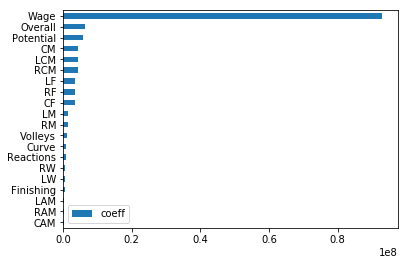

In [8]:
# Create new DataFrame with the coefficients per each feature
coeff_df = pd.DataFrame(data=lin_reg.coef_[0], index=features, columns=["coeff"])
coeff_df.sort_values(by="coeff", ascending=False, inplace=True) # Sort 'coeff_df' in descending order

coeff_df.iloc[0:20].sort_values(by="coeff").plot.barh();

In [9]:
display("Independent term: {0}".format(lin_reg.intercept_[0]))

# If all the features values are 0, the predictions must be equal to the independent term. Let's check this!
X_zeros = np.zeros(shape=(1, X_train.shape[1]))
display("Prediction result made with an array of zeros: {}".format(lin_reg.predict(X_zeros)))

'Independent term: 436808.08502277127'

'Prediction result made with an array of zeros: [[436808.08502277]]'

Saves the prediction in *predictions_lin_reg*

In [10]:
predictions_lin_reg = lin_reg.predict(X_test)

### Polynomial Regression Model <a id="polynomial_regression"></a>
A simple way to use a linear model to fit nonlinear data is to add powers of each feature as new features, and then train a linear model on this extended set of features.

In [11]:
d = 2 # Polynomial degree
poly_features = PolynomialFeatures(degree=d, include_bias=False)

# Add the square of each feature and the combinations of features up to 2 degree
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

The number of features created by *PolynomialFeatures* can be calculated with the following equation:

\begin{align}
\frac{(n + d)!}{d!n!}\
\end{align}

In [12]:
n = X.shape[1]
poly_features_count = int(math.factorial(n + d) / (math.factorial(d) * math.factorial(n))) - 1

display(md("*X_train_poly* should now have {0} features".format(poly_features_count)))

display(md("*X* shape: {0}".format(X.shape)))
display(md("*X_train_poly* shape: {0}".format(X_train_poly.shape)))
display(md("*X_test_poly* shape: {0}".format(X_test_poly.shape)))

*X_train_poly* should now have 860 features

*X* shape: (15952, 40)

*X_train_poly* shape: (12761, 860)

*X_test_poly* shape: (3191, 860)

In [13]:
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
predictions_poly = poly_reg.predict(X_test_poly)

### Lasso Regression<a id="lasso_regression"></a>
Is a regularized version of *Linear Regression*. It adds a regularization term to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

In [14]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=1)
lasso_reg.fit(X_train_poly, y_train)
predictions_lasso = lasso_reg.predict(X_test_poly)

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Linear Regression Model (TensorFlow)<a id="linear_regression_tf"></a>
Let´s make a *Linear Regression* with *TensorFlow* library.

In [15]:
tf.reset_default_graph()

n_epochs = 20000
learning_rate = 0.05

X_train_tf = np.c_[np.ones((X_train.shape[0], 1)), X_train]

# 'y_pred_tf' = 'X_tf' * 'theta'
X_tf = tf.constant(X_train_tf, dtype=tf.float32, name="X")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred_tf = tf.matmul(X_tf, theta, name="predictions")

# Calculates the error ('y_pred_tf' - 'y_tf')
y_tf = tf.constant(y_train, dtype=tf.float32, name="y")
error = y_pred_tf - y_tf
mse = tf.reduce_mean(tf.square(error), name="mse")

In [16]:
# Minimizes the MSE with Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [17]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 1000 == 0:
            print("Epoch {0} - RMSE: {1}".format(epoch,np.sqrt(mse.eval())))
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 - RMSE: 5929636.5
Epoch 1000 - RMSE: 3723522.5
Epoch 2000 - RMSE: 3512794.25
Epoch 3000 - RMSE: 3366287.25
Epoch 4000 - RMSE: 3247592.0
Epoch 5000 - RMSE: 3148548.75
Epoch 6000 - RMSE: 3065275.25
Epoch 7000 - RMSE: 2995148.0
Epoch 8000 - RMSE: 2936111.25
Epoch 9000 - RMSE: 2886461.75
Epoch 10000 - RMSE: 2844758.0
Epoch 11000 - RMSE: 2809770.75
Epoch 12000 - RMSE: 2780451.5
Epoch 13000 - RMSE: 2755905.0
Epoch 14000 - RMSE: 2735372.25
Epoch 15000 - RMSE: 2718209.75
Epoch 16000 - RMSE: 2703872.75
Epoch 17000 - RMSE: 2691901.5
Epoch 18000 - RMSE: 2681909.75
Epoch 19000 - RMSE: 2673572.0


In [18]:
X_test_tf = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Makes the predictions: 'X_test_tf' * 'best_theta'
predictions_lin_reg_tf = np.matmul(X_test_tf, best_theta)

## Model Evaluation <a id="evaluation"></a>
### RMSE <a id="rmse"></a>

In [19]:
lin_mse = mean_squared_error(predictions_lin_reg, y_test)
poly_mse = mean_squared_error(predictions_poly, y_test)
lasso_mse = mean_squared_error(predictions_lasso, y_test)
lin_reg_tf_mse = mean_squared_error(predictions_lin_reg_tf, y_test)
lin_rmse = np.sqrt(lin_mse)
poly_rmse = np.sqrt(poly_mse)
lasso_rmse = np.sqrt(lasso_mse)
lin_reg_tf_rmse = np.sqrt(lin_reg_tf_mse)

display(md("**Linear Regression - Root Mean Squared Error: €{0:,}**".format(int(lin_rmse))))
display(md("**Polynomial Regression - Root Mean Squared Error: €{0:,}**".format(int(poly_rmse))))
display(md("**Lasso Regression - Root Mean Squared Error: €{0:,}**".format(int(lasso_rmse))))
display(md("**Linear Regression (TensorFlow) - Root Mean Squared Error: €{0:,}**".format(int(lin_reg_tf_rmse))))

**Linear Regression - Root Mean Squared Error: €2,568,666**

**Polynomial Regression - Root Mean Squared Error: €1,341,029**

**Lasso Regression - Root Mean Squared Error: €1,349,606**

**Linear Regression (TensorFlow) - Root Mean Squared Error: €2,574,472**

### Cross Validation <a id="cross_validation"></a>

In [20]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

poly_scores = cross_val_score(poly_reg, X_train_poly, y_train, scoring="neg_mean_squared_error", cv=5)
poly_rmse_scores = np.sqrt(-poly_scores)

lasso_scores = cross_val_score(lasso_reg, X_train_poly, y_train, scoring="neg_mean_squared_error", cv=5)
lasso_rmse_scores = np.sqrt(-lasso_scores)

display(md("**Linear Regression Model**"))
display(md("Scores: {0}".format(lin_rmse_scores)))
display(md("Mean: {0:,.2f}".format(lin_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(lin_rmse_scores.std())))

display(md("**Polynomial Regression Model**"))
display(md("Scores: {0}".format(poly_rmse_scores)))
display(md("Mean: {0:,.2f}".format(poly_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(poly_rmse_scores.std())))

display(md("**Lasso Regression Model**"))
display(md("Scores: {0}".format(lasso_rmse_scores)))
display(md("Mean: {0:,.2f}".format(lasso_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(lasso_rmse_scores.std())))

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want t

**Linear Regression Model**

Scores: [2644961.76555118 2669757.77220951 2758873.51134806 2588098.54221285
 2532726.45229108]

Mean: 2,638,883.61

Standard deviation: 76,467.25

**Polynomial Regression Model**

Scores: [1402901.4400017  1313532.52491058 1380716.31062106 1504650.95869505
 1313855.00159092]

Mean: 1,383,131.25

Standard deviation: 70,437.08

**Lasso Regression Model**

Scores: [1394715.12887811 1285591.24839984 1358183.84110789 1474467.15362999
 1289163.70449484]

Mean: 1,360,424.22

Standard deviation: 70,519.09

### Learning Curves <a id="learning_curves"></a>
These are plots of the model's performance on the training set and the validation set as a function of the training set size. These plots help us to analyze if the models are *underfitting* or *overfitting* the data.

In [21]:
def plot_learning_curves(model, X, y, step=500):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    x_values = range(1, len(X_train), step)
    for m in x_values:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(x_values, np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(x_values, np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.yscale("log")  

The **Linear Regression Model** is underfitting the data. The curves reached a plateau, and adding more training examples don't help. We have to use a more complex model (*Polynomial Regression Model*) or come up with better features.

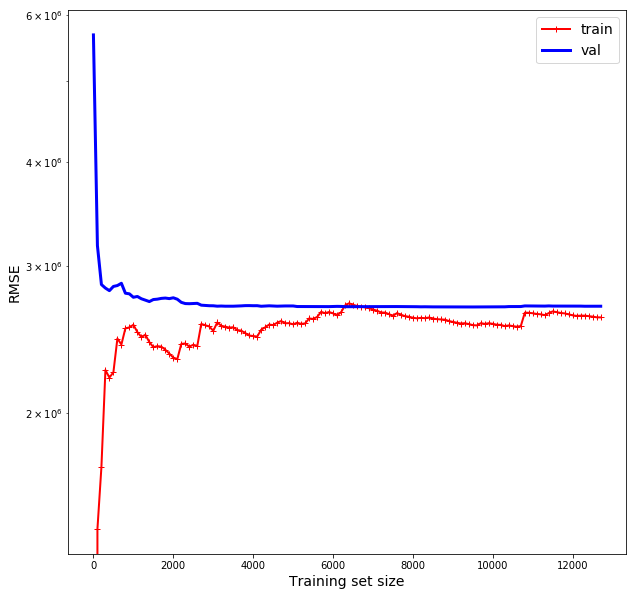

In [22]:
# # Plots the learning curves for the Linear Regression Model
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_learning_curves(lin_reg, X, y, step=100)
plt.show()

The **Polynomial Regression Model** overfits (the gap between the curves is significant). However, the *RMSE* is much lower than in *Linear Regression Model*.

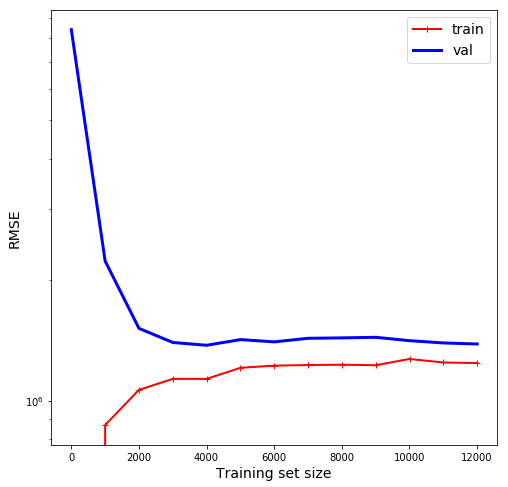

In [23]:
# Plots the learning curves for the Polynomial Regression Model
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
X_poly = np.append(X_train_poly, X_test_poly, axis=0)
y_poly = np.append(y_train, y_test, axis=0)
plot_learning_curves(poly_reg, X_poly, y_poly, step=1000)
plt.show()

## Export the results <a id="export"></a>

In [24]:
predictions_series = pd.Series(data=predictions_lin_reg.flatten().tolist(), name="Prediction Linear Regression")
predictions_poly_series = pd.Series(data=predictions_poly.flatten().tolist(), name="Prediction Polynomial Regression")
predictions_lasso_series = pd.Series(data=predictions_lasso.flatten().tolist(), name="Prediction Lasso Regression")
predictions_lin_reg_tf_series = pd.Series(data=predictions_lin_reg_tf.flatten().tolist(), 
                                          name="Prediction Lasso Regression (TF)")

X_test_df = pd.DataFrame(data=X_test, columns=features)
y_test_series = pd.Series(data=y_test.flatten().tolist(), name="Value")
results_df = pd.concat([X_test_df, y_test_series, predictions_series, predictions_poly_series, 
                        predictions_lasso_series, predictions_lin_reg_tf_series], axis=1, ignore_index=False)

display(results_df.head())

results_df.to_csv("data/output/predictions.csv", sep=";", index=False, float_format="%.0f")

,Overall,Potential,Wage,Special,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Long passing,Long shots,Positioning,Reactions,Short passing,Shot power,Vision,Volleys,CAM,CDM,CF,CM,LAM,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RCM,RDM,RF,RM,RS,RW,RWB,ST,Value,Prediction Linear Regression,Prediction Polynomial Regression,Prediction Lasso Regression,Prediction Lasso Regression (TF)
0,0.625000,0.625000,0.024779,0.769034,0.804598,0.758242,0.732558,0.720930,0.789474,0.752688,0.764045,0.767442,0.764045,0.763441,0.647059,0.792683,0.824176,0.761905,0.701149,0.738462,0.542373,0.738462,0.701754,0.738462,0.701754,0.542373,0.738462,0.741935,0.704918,0.753846,0.547170,0.738462,0.701754,0.542373,0.738462,0.741935,0.704918,0.753846,0.547170,0.704918,8500000.0,4.228160e+06,6.311192e+06,6.315971e+06,4.811987e+06
1,0.291667,0.458333,0.003540,0.516955,0.563218,0.527473,0.581395,0.546512,0.610526,0.387097,0.303371,0.453488,0.438202,0.473118,0.264706,0.560976,0.439560,0.369048,0.160920,0.400000,0.491525,0.400000,0.385965,0.400000,0.385965,0.491525,0.400000,0.467742,0.327869,0.461538,0.528302,0.400000,0.385965,0.491525,0.400000,0.467742,0.327869,0.461538,0.528302,0.327869,260000.0,-6.005568e+05,-2.720894e+05,1.305543e+05,-9.098700e+05
2,0.479167,0.708333,0.028319,0.614203,0.735632,0.736264,0.627907,0.767442,0.736842,0.677419,0.764045,0.662791,0.707865,0.634409,0.500000,0.670732,0.626374,0.678571,0.643678,0.630769,0.355932,0.615385,0.561404,0.630769,0.561404,0.355932,0.615385,0.629032,0.491803,0.646154,0.358491,0.630769,0.561404,0.355932,0.615385,0.629032,0.491803,0.646154,0.358491,0.491803,1800000.0,5.328109e+06,3.747483e+06,3.521859e+06,5.311829e+06
3,0.375000,0.479167,0.007080,0.661548,0.632184,0.615385,0.534884,0.453488,0.652632,0.419355,0.415730,0.651163,0.662921,0.623656,0.485294,0.658537,0.769231,0.619048,0.551724,0.538462,0.644068,0.538462,0.578947,0.538462,0.578947,0.644068,0.538462,0.564516,0.475410,0.538462,0.622642,0.538462,0.578947,0.644068,0.538462,0.564516,0.475410,0.538462,0.622642,0.475410,600000.0,5.103353e+05,-1.673899e+04,5.820581e+03,5.101984e+05
4,0.333333,0.395833,0.001770,0.637876,0.632184,0.626374,0.616279,0.616279,0.515789,0.569892,0.662921,0.569767,0.573034,0.698925,0.500000,0.658537,0.681319,0.547619,0.540230,0.523077,0.559322,0.523077,0.543860,0.523077,0.543860,0.559322,0.523077,0.548387,0.491803,0.538462,0.566038,0.523077,0.543860,0.559322,0.523077,0.548387,0.491803,0.538462,0.566038,0.491803,375000.0,-4.845756e+05,-6.523218e+04,7.390803e+05,-9.186241e+05
